## Meridional Heat Transport by stationary and transient eddies

In [1]:
import matplotlib as mpl
import numpy as np
import xray as xr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import cartopy.feature as feature
import cartopy.crs as ccrs
import iris
import iris.analysis.cartography
import iris.quickplot as qplt
import iris.plot as iplt
#from ctd import plot_section
from oceans.colormaps import cm
from oceans.colormaps import cm as ocncm
from mpl_toolkits.basemap import cm as bmcm
from matplotlib.colors import LinearSegmentedColormap as LSC

from iris.coords import DimCoord


from netCDF4 import Dataset
#gridline stuff
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.stats.stats import pearsonr   

import scipy.ndimage as ndimage


import dask
%matplotlib inline

In [2]:
import resource
import time

usage = resource.getrusage(resource.RUSAGE_SELF)

for name, desc in [
    ('ru_utime', 'User time'),
    ('ru_stime', 'System time'),
    ('ru_maxrss', 'Max. Resident Set Size'),
    ('ru_ixrss', 'Shared Memory Size'),
    ('ru_idrss', 'Unshared Memory Size'),
    ('ru_isrss', 'Stack Size'),
    ('ru_inblock', 'Block inputs'),
    ('ru_oublock', 'Block outputs'),
    ]:
    print '%-25s (%-10s) = %s' % (desc, name, getattr(usage, name))


User time                 (ru_utime  ) = 2.332
System time               (ru_stime  ) = 0.644
Max. Resident Set Size    (ru_maxrss ) = 164348
Shared Memory Size        (ru_ixrss  ) = 0
Unshared Memory Size      (ru_idrss  ) = 0
Stack Size                (ru_isrss  ) = 0
Block inputs              (ru_inblock) = 250720
Block outputs             (ru_oublock) = 128


### set resource limits so I don't kill my desktop when I run out of memory

In [3]:
#soft, hard = resource.getrlimit(resource.RLIMIT_RSS)
#print 'Soft limit starts as  :', soft
#print 'Hard limit starts as  :', hard

#resource.setrlimit(resource.RLIMIT_RSS, (100, 100))
size=50000*1024*1024 # bytes
resource.setrlimit(resource.RLIMIT_AS, (size, resource.RLIM_INFINITY))

soft, hard = resource.getrlimit(resource.RLIMIT_AS)
print 'Soft limit starts as  :', soft
print 'Hard limit starts as  :', hard


Soft limit starts as  : 52428800000
Hard limit starts as  : -1


In [6]:
#memory_sink = ['a']*3000000000  # this should fail

In [7]:
print("numpy version: ", np.__version__)
print("matplotlib version: ", mpl.__version__)
print("xarray version: ", xr.__version__)
print("pandas version: ", pd.__version__)

('numpy version: ', '1.10.4')
('matplotlib version: ', '1.5.1')
('xarray version: ', '0.8.2')
('pandas version: ', u'0.18.0')


In [8]:
def setaxesfsize(axl,fontsize):
    ticklabelbot = axl.get_xticklabels()
    ticklabelleft = axl.get_yticklabels()
    for labelx in ticklabelbot:
        labelx.set_fontsize(fontsize)
    for labely in ticklabelleft:
            labely.set_fontsize(fontsize)


In [9]:
seas=["DJF","MAM","JJA","SON","ANN"]
timeseg=["170912_499902","171003_499905","171006_499908","171009_499911","170912_499911"]
vars=["T","U","V","OMEGA","Q","VT","VQ","OMEGAT","VBSTAR_TBSTAR","VBSTAR_QBSTAR","OBSTAR_TBSTAR","VPTP_BAR","VPQP_BAR","OPTP_BAR","ZMMSF"]
case="_cesmi6gafv1vdp"
seastimeseg=["DJF_170912_499902_","MAM_171003_499905_","JJA_171006_499908_","SON_171009_499911_","ANN_170912_499911_"]

#### Load the local data with xarray

In [12]:
#create the merged xarray Dataset
diagdir="/scratch/guido/diagdata/vt_qt/"

xrdjf=xr.Dataset()
sindex=0
svar=seas[sindex]
for vvar in vars:
    fname=seastimeseg[sindex]+vvar+case+".nc"
    #print (diagdir+fname)
    tmpds=xr.open_dataset(diagdir+fname)
    xrdjf=xr.Dataset.merge(xrdjf,tmpds)

xrmam=xr.Dataset()
sindex=1
svar=seas[sindex]
for vvar in vars:
    fname=seastimeseg[sindex]+vvar+case+".nc"
    #print (diagdir+fname)
    tmpds=xr.open_dataset(diagdir+fname)
    xrmam=xr.Dataset.merge(xrmam,tmpds)

xrjja=xr.Dataset()
sindex=2
svar=seas[sindex]
for vvar in vars:
    fname=seastimeseg[sindex]+vvar+case+".nc"
    #print (diagdir+fname)
    tmpds=xr.open_dataset(diagdir+fname)
    xrjja=xr.Dataset.merge(xrjja,tmpds)

xrson=xr.Dataset()
sindex=3
svar=seas[sindex]
for vvar in vars:
    fname=seastimeseg[sindex]+vvar+case+".nc"
    #print (diagdir+fname)
    tmpds=xr.open_dataset(diagdir+fname)
    xrson=xr.Dataset.merge(xrson,tmpds)

xrann=xr.Dataset()
sindex=4
svar=seas[sindex]
for vvar in vars:
    fname=seastimeseg[sindex]+vvar+case+".nc"
    #print (diagdir+fname)
    tmpds=xr.open_dataset(diagdir+fname)
    xrann=xr.Dataset.merge(xrann,tmpds)


In [20]:
print (xrdjf)

<xarray.Dataset>
Dimensions:        (lat: 192, lev_p: 40, time: 329)
Coordinates:
  * time           (time) datetime64[ns] 1714-08-01T12:00:00 ...
  * lev_p          (lev_p) float32 25.0 50.0 75.0 100.0 125.0 150.0 175.0 ...
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 ...
Data variables:
    T              (time, lev_p, lat) float64 240.2 240.2 240.2 240.2 240.2 ...
    U              (time, lev_p, lat) float64 0.0 -0.03267 -0.06575 -0.1002 ...
    V              (time, lev_p, lat) float64 0.0 0.005231 -0.00508 0.001987 ...
    OMEGA          (time, lev_p, lat) float64 4.423e-06 4.42e-06 1.22e-05 ...
    Q              (time, lev_p, lat) float64 1.302e-06 1.302e-06 1.301e-06 ...
    VT             (time, lev_p, lat) float64 0.0 1.183 -1.368 0.2604 ...
    VQ             (time, lev_p, lat) float64 0.0 6.642e-09 -6.819e-09 ...
    OMEGAT         (time, lev_p, lat) float64 0.001036 0.001036 0.002891 ...
    VBSTAR_TBSTAR  (time, lev_p, lat) float64 0.0 -0.000

In [21]:
xrdjf.coords

Coordinates:
  * time     (time) datetime64[ns] 1714-08-01T12:00:00 1724-08-01T12:00:00 ...
  * lev_p    (lev_p) float32 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...

In [22]:
print xrdjf.time

<xarray.DataArray 'time' (time: 329)>
array(['1714-08-01T12:00:00.000000000Z', '1724-08-01T12:00:00.000000000Z',
       '1734-08-01T12:00:00.000000000Z', '1744-08-01T12:00:00.000000000Z',
       '1754-08-01T12:00:00.000000000Z', '1764-08-01T12:00:00.000000000Z',
       '1774-08-01T12:00:00.000000000Z', '1784-08-01T12:00:00.000000000Z',
       '1794-08-01T12:00:00.000000000Z', '1804-08-01T12:00:00.000000000Z',
       '1814-08-01T12:00:00.000000000Z', '1824-08-01T12:00:00.000000000Z',
       '1834-08-01T12:00:00.000000000Z', '1844-08-01T12:00:00.000000000Z',
       '1854-08-01T12:00:00.000000000Z', '1864-08-01T12:00:00.000000000Z',
       '1874-08-01T12:00:00.000000000Z', '1884-08-01T12:00:00.000000000Z',
       '1894-08-01T12:00:00.000000000Z', '1904-08-01T12:00:00.000000000Z',
       '1914-08-01T12:00:00.000000000Z', '1924-08-01T12:00:00.000000000Z',
       '1934-08-01T12:00:00.000000000Z', '1944-08-01T12:00:00.000000000Z',
       '1954-08-01T12:00:00.000000000Z', '1964-08-01T12:00:00.

In [23]:
#EDML and WDC pressure at elevation
def pz(elev):
    H=7500. #scale height meters
    p0=1000. #mb
    p=p0*np.exp(-elev/H)
    return p

def pp(pres):
    H=7500. #scale height meters
    p0=1000. #mb
    z=-H*np.log(pres/p0)
    return z

#EDML 2892 meters

print pz(2892)

#WDC 1776 meters

print pz(1776)


680.042488279
789.149102056


In [24]:
levs_z=pp(xrdjf.lev_p)
print levs_z

<xarray.DataArray 'lev_p' (lev_p: 40)>
array([ 27666.59570312,  22467.9921875 ,  19427.00390625,  17269.38867188,
        15595.81152344,  14228.40039062,  13072.26953125,  12070.78417969,
        11187.41113281,  10397.20800781,   9682.38085938,   9029.79589844,
         8429.47558594,   7873.66552734,   7356.21923828,   6872.18017578,
         6417.49560547,   5988.80761719,   5583.30371094,   5198.60400391,
         4832.67822266,   4483.77734375,   4150.38964844,   3831.19189453,
         3525.02734375,   3230.87207031,   2947.81933594,   2675.06225586,
         2411.87695312,   2157.61572266,   1911.69213867,   1673.57653809,
         1442.78930664,   1218.89172363,   1001.4854126 ,    790.20410156,
          584.71142578,    384.69979858,    189.88337708,     -0.        ], dtype=float32)
Coordinates:
  * lev_p    (lev_p) float32 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 ...


In [33]:
tlen=xrdjf.dims["time"]

In [34]:
ytime=np.linspace(1715,4995,tlen)
print ytime

[ 1715.  1725.  1735.  1745.  1755.  1765.  1775.  1785.  1795.  1805.
  1815.  1825.  1835.  1845.  1855.  1865.  1875.  1885.  1895.  1905.
  1915.  1925.  1935.  1945.  1955.  1965.  1975.  1985.  1995.  2005.
  2015.  2025.  2035.  2045.  2055.  2065.  2075.  2085.  2095.  2105.
  2115.  2125.  2135.  2145.  2155.  2165.  2175.  2185.  2195.  2205.
  2215.  2225.  2235.  2245.  2255.  2265.  2275.  2285.  2295.  2305.
  2315.  2325.  2335.  2345.  2355.  2365.  2375.  2385.  2395.  2405.
  2415.  2425.  2435.  2445.  2455.  2465.  2475.  2485.  2495.  2505.
  2515.  2525.  2535.  2545.  2555.  2565.  2575.  2585.  2595.  2605.
  2615.  2625.  2635.  2645.  2655.  2665.  2675.  2685.  2695.  2705.
  2715.  2725.  2735.  2745.  2755.  2765.  2775.  2785.  2795.  2805.
  2815.  2825.  2835.  2845.  2855.  2865.  2875.  2885.  2895.  2905.
  2915.  2925.  2935.  2945.  2955.  2965.  2975.  2985.  2995.  3005.
  3015.  3025.  3035.  3045.  3055.  3065.  3075.  3085.  3095.  3105.
  3115

#### Time mean of the meridional mean component

In [57]:
def tmeanmerid(xdata):
    # mean meridional sensible heat transport
    #cp g^-1 P0 = 10^7 J K^-1 m^-2
    vtdat=np.ma.masked_invalid(xdata['VT'].data) # K m/s 
    lats=xdata.lat
    levs=xdata.lev_p
    vt_tavg=np.average(vtdat,axis=0)

    # mean meridional latent heat transport
    #cp g^-1 P0 = 10^7 J K^-1 m^-2
    vqdat=np.ma.masked_invalid(xdata['VQ'].data) # m/s kg/kg
    lats=xdata.lat
    levs=xdata.lev_p
    vq_tavg=np.average(vqdat,axis=0)

    udat=np.ma.masked_invalid(xdata['U'].data) # m/s
    lats=xdata.lat
    levs=xdata.lev_p
    u_tavg=np.average(udat,axis=0)

    # mean meridional V
    vdat=np.ma.masked_invalid(xdata['V'].data) # m/s
    lats=xdata.lat
    levs=xdata.lev_p
    v_tavg=np.average(vdat,axis=0)

    # mean meridional T
    tdat=np.ma.masked_invalid(xdata['T'].data) # K
    lats=xdata.lat
    levs=xdata.lev_p
    t_tavg=np.average(tdat,axis=0)

    # mean meridional Q
    qdat=np.ma.masked_invalid(xdata['Q'].data) # 
    lats=xdata.lat
    levs=xdata.lev_p
    q_tavg=np.average(qdat,axis=0)
    
    # meridional streamfunction
    #cp g^-1 P0 = 10^7 J K^-1 m^-2
    msf=np.ma.masked_invalid(xdata['ZMMSF'].data) # kg/s
    lats=xdata.lat
    levs=xdata.lev_p
    msf_tavg=np.average(msf,axis=0)


    return t_tavg,u_tavg,v_tavg,q_tavg,vt_tavg,vq_tavg,msf_tavg

In [58]:
tmm,umm,vmm,qmm,vtmm,vqmm,sfmm=tmeanmerid(xrdjf)

#### Time mean of the stationary eddy component

In [59]:
def tmeanstat(xdata):
    # stationary eddy sensible heat transport
    #cp g^-1 P0 = 10^7 J K^-1 m^-2
    vbstbsdata=np.ma.masked_invalid(xdata['VBSTAR_TBSTAR'].data) # K m/s
    lats=xdata.lat
    levs=xdata.lev_p
    vbstbs_tavg=np.average(vbstbsdata,axis=0)

    # stationary eddy latent heat transport
    #cp g^-1 P0 = 10^7 J K^-1 m^-2
    vbsqbsdata=np.ma.masked_invalid(xdata['VBSTAR_QBSTAR'].data) # K m/s
    lats=xdata.lat
    levs=xdata.lev_p
    vbsqbs_tavg=np.average(vbsqbsdata,axis=0)

    return vbstbs_tavg,vbsqbs_tavg

In [60]:
vtstat,vqstat=tmeanstat(xrdjf)

#### Time mean of the transient eddy component

In [61]:
def tmeaneddy(xdata):
    # transient eddy sensible heat transport
    #cp g^-1 P0 = 10^7 J K^-1 m^-2
    vptpdat=np.ma.masked_invalid(xdata['VPTP_BAR'].data) # K m/s
    lats=xdata.lat
    levs=xdata.lev_p
    vptp_tavg=np.average(vptpdat,axis=0)

    #vertical
    optpdat=np.ma.masked_invalid(xdata['OPTP_BAR'].data) # K Pa/s
    optptavg=np.average(optpdat,axis=0)

    # transient eddy latent heat transport
    #Lv = 2.5e6 J kg^-1
    vpqpdat=np.ma.masked_invalid(xdata['VPQP_BAR'].data) # kg/kg m/s
    lats=xdata.lat
    levs=xdata.lev_p
    vpqp_tavg=np.average(vpqpdat,axis=0)

    return vptp_tavg,vpqp_tavg


In [62]:
vteddy,vqeddy=tmeaneddy(xrdjf)

In [68]:
lats=xrdjf.lat.data
levs=xrdjf.lev_p.data

In [69]:
print levs[36]
print lats[47]
print lats[144]

925.0
-45.7068062827
45.7068062827


#### plotting function

In [77]:
def plot_sensible_eddy(xarray,vptptavg,msftavg,lats,levs):
    vptps45=xarray["VPTP_BAR"][:,36,47]
    vptpn45=xarray["VPTP_BAR"][:,36,144]
    
    fig=plt.figure(figsize=(16,12))
    lfsize=14

    ax=plt.subplot(311)

    colmap=ocncm.odv
    clevs=np.linspace(-35,35,35)
    p1=ax.contourf(lats,levs,vptptavg,levels=clevs,cmap=colmap,extend='both')
    ax.set_ylabel("Height (mb)",fontsize=lfsize)
    ax.set_xlabel("Latitude ($^\circ$)",fontsize=lfsize)
    ax.set_xlim(-90,90)
    ax.set_ylim(0,1000)
    ax.invert_yaxis()

    # mark the WDC and EDML locations
    ax.scatter(-75,pz(2892),s=50,marker='o',color='r') #EDML
    ax.scatter(-79.,pz(1776),s=50,marker='o',color='b') #WDC

    # streamfunction
    msflevs=np.linspace(-1,1,20)
    ax.contour(lats,levs,msftavg*1.0e-11,levels=msflevs,colors='k')
    setaxesfsize(ax,14)

    pos = ax.get_position()
    l, b, w, h = pos.bounds

    cbarxoffset=0.01
    cbaryoffset=0.0
    barfsize=16
    lfsize=14
    ctax = fig.add_axes([l+w+cbarxoffset, b+cbaryoffset, 0.03, h]) # setup colorbar axes
    cb = plt.colorbar(p1, orientation='vertical',cax=ctax, ticks=np.linspace(-40,40,21))
    #cb.ax.set_yticklabels(['-50.','-25','0.00','25.','50.'])  # vertically oriented colorbar
    cbarstr="Meridional Transient Eddy\nSensible Heat Transport (K m s$^{-1}$)"
    cb.set_label(cbarstr,fontsize=lfsize,y=0.5)
    #cbohc.ax.yaxis.set_ticks_position('right')
    cb.ax.tick_params(labelsize=barfsize) 
    for label in cb.ax.yaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    # Southern and Northern Transient Eddy Activity

    ax1=plt.subplot(312)

    #ax1.plot(ytime,vptps45,color='r',label='SZW')
    ax1.plot(ytime,vptpn45,color='blue',label='NT')
    ax1.set_xlabel('Time (years)',size=lfsize)
    ax1.set_ylabel('Meridional Heat\nTransport (K m/s)',size=lfsize)
    setaxesfsize(ax1,14)
    ax1.legend()

    ax2=plt.subplot(313)

    ax2.plot(ytime,vptps45,color='r',label='ST')
    #ax2.plot(ytime,vptpn45,color='blue',label='NZW')
    ax2.set_xlabel('Time (years)',size=lfsize)
    ax2.set_ylabel('Meridional Heat\nTransport (K m/s)',size=lfsize)
    setaxesfsize(ax2,14)
    ax2.legend()

    textcol='white'
    tmsize=12
    bbpad=5
    balp=1.0
    ax.text(45, 925, 'NT', style='normal',fontsize=tmsize, color=textcol,
            bbox={'facecolor':'green', 'alpha':balp, 'pad':bbpad})
    ax.text(-45, 925, 'ST', style='normal',fontsize=tmsize, color=textcol,
            bbox={'facecolor':'red', 'alpha':balp, 'pad':bbpad})


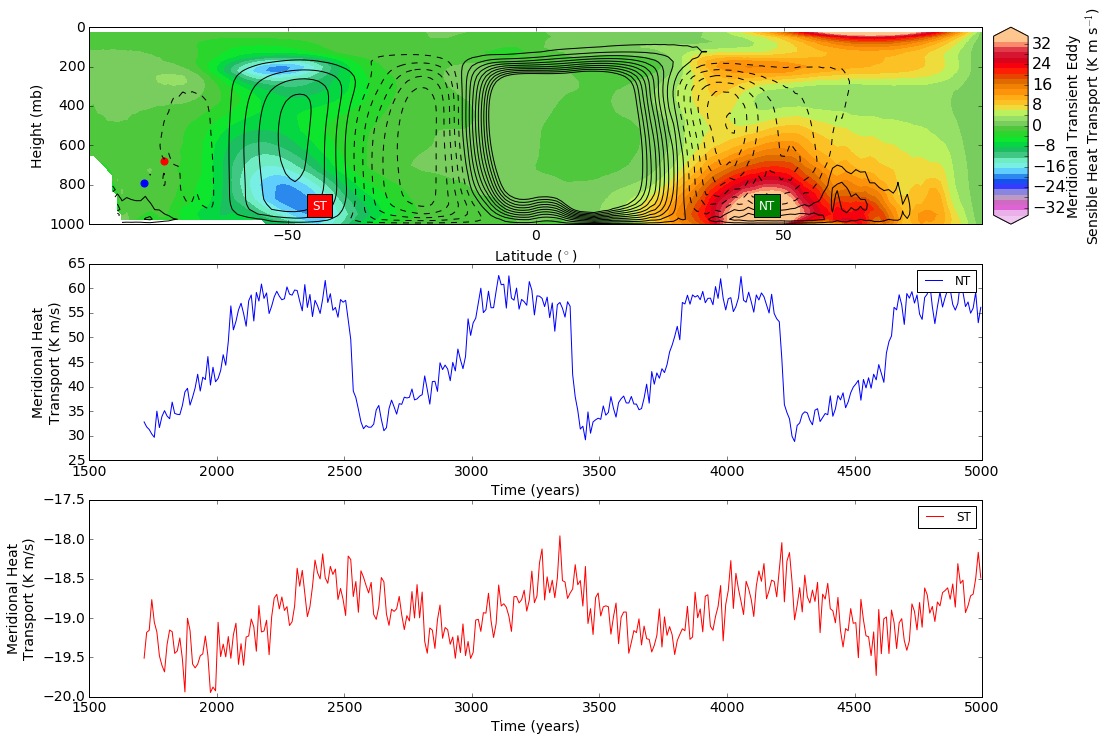

In [78]:
plot_sensible_eddy(xrdjf,vteddy,sfmm,lats,levs)